In [88]:
import os
import uuid
import warnings
from typing import List, TypedDict, Annotated

warnings.filterwarnings("ignore")

from IPython.display import Markdown


from pydantic import BaseModel, Field


from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    AIMessage,
    SystemMessage
)
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig

from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


from langchain_community.vectorstores.pgvector import PGVector

from tqdm import tqdm
from langgraph.graph import (
    StateGraph,
    START,
    END,
    MessagesState
)
from langgraph.graph.message import add_messages
from langgraph.store.base import BaseStore

from supabase import create_client

from supabase import create_client
from typing import List

from langchain_core.documents import Document
from langchain_community.document_loaders import DirectoryLoader

from dotenv import load_dotenv
load_dotenv(dotenv_path=r"C:\Users\hasee\Desktop\Legal Chatbot\.env")

True

In [89]:
CONNECTION_STRING = os.environ.get("CONNECTION_STRING","")
SUPERBASE_SERVICE_ROLE_KEY = os.environ.get("SUPERBASE_SERVICE_ROLE_KEY","")
SUPABASE_URL = os.environ.get("SUPABASE_URL","")

In [90]:
from sqlalchemy import create_engine
engine = create_engine(CONNECTION_STRING)
with engine.connect() as conn:
    print("Connected to Supabase Postgres")

Connected to Supabase Postgres


In [ ]:
from supabase import create_client


supabase_client = create_client(SUPABASE_URL,SUPERBASE_SERVICE_ROLE_KEY)
print("Succefully coonectd to Supabase client")

Succefully coonectd to Supabase client


In [5]:
# chatting llm
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
#embedding llm
EMBEDDING = OpenAIEmbeddings(model="text-embedding-3-small")

In [6]:
class AgentState(TypedDict):
    documents_path:str
    documents:list[Document]
    chunks:list[Document] 
    vectorstore:PGVector | None
    collection_name:str
    retrieved_docs:list[Document]
    context: str 
    answer:str
    vectorstore_path:str
    messages: Annotated[list[BaseMessage], add_messages]
    # metadata
    doc_id:str




PROMPT_TEMPLATE = """
        You are an expert Legal AI Assistant for Pakistan. Your task is to answer legal questions based strictly on the provided context.

        Instructions:
        1. Source-Based Answering: Answer the question using ONLY the information provided in the Context below. Do not use outside knowledge.
        2. Specific Legal Citations: When making a statement, you must cite the specific legal authority found in the text (e.g., "Article 6 of the Constitution", "Section 302 of PPC", "Clause 3"). 
        3. Citation Format: Format citations as: [Legal Reference]** (Found in: Chunk ID/Source).
            Example: "Every citizen has the right to a fair trial as per Article 10-A (Source: Chunk 2, constitution.pdf).."
        4. No Hallucinations:** If the provided context does not contain the answer, state: "The provided context does not contain sufficient information to answer this question."

        Context:
        {context}

        Question:
        {question}

        Answer:
        """

# Document Loading and Text Splitting

In [7]:
def document_loader(state: AgentState):
    path = os.path.abspath(state["documents_path"])  # ensure absolute
    if os.path.isfile(path):  # single PDF case
        loader = PyPDFLoader(path)
        documents = loader.load()
        # add meta data as langchain preserve it
        for doc in documents:
            doc.metadata["doc_id"] = state["doc_id"]
    elif os.path.isdir(path):  # directory case
        loader = DirectoryLoader(
            path=path,
            glob="*.pdf",
            loader_cls=PyPDFLoader)
        documents = loader.load()
        for doc in documents:
            doc.metadata["doc_id"] = state["doc_id"]
    else:
        raise ValueError(f"Invalid documents_path: {path}")
    state["documents"] = documents
    return state



def text_splitter(state: AgentState):
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=199)
    
    chunks = splitter.split_documents(state["documents"])

    # add metadata (manual table will store this)
    for i, chunk in enumerate(chunks):
        metadata = {
            "doc_id": state["doc_id"],
            "chunk_index": i,
            "file_name": os.path.basename(state["documents_path"])
        }
        chunk.metadata.update(metadata)

    state["chunks"] = chunks
    return state


``PGVector = LangChain-controlled table``  
``Manual insert = Your-controlled table``

# Create and Load Vectorstore

In [66]:
#1. Use this when you want:
    # Full SQL control
    # Custom schema
    # No LangChain retriever
    # Raw pgvector queries

# 2. You must write your own similarity SQL
    # LangChain retriever will NOT work
    # You control schema 100%

def create_vector_store_manual(state: AgentState,batch_size: int = 20):
    """
    Manual Supabase + pgvector ingestion
    LangChain PGVector must NOT be used
    """

    chunks = state["chunks"]

    for i in tqdm(range(0, len(chunks), batch_size),desc="Uploading chunks manually"):
        batch = chunks[i:i + batch_size]

        texts = [c.page_content for c in batch]
        embeddings = EMBEDDING.embed_documents(texts)

        rows = [
            {
                "doc_id": c.metadata["doc_id"],
                "chunk_index": c.metadata["chunk_index"],
                "content": c.page_content,
                "embedding": emb,
                "metadata": c.metadata
            }
            for c, emb in zip(batch, embeddings)
        ]

        # Insert EACH batch (important)
        # supabase_client.table(state["collection_name"]).insert(rows).execute()
        # upser make sure thier is no duplication
        # key columns to avoid duplicates
        supabase_client.table(state["collection_name"]).upsert(rows,on_conflict="doc_id,chunk_index").execute()  
    print(f"Uploaded {len(chunks)} chunks manually to Supabase")
    return state


# Retriever

In [67]:
def search_chunks(state:AgentState, top_k: int = 5):
    """Search for relevant chunks"""
    human_messages = [
        m for m in state.get("messages", []) if isinstance(m, HumanMessage)
    ]
    query = human_messages[-1].content
    query_emb = EMBEDDING.embed_query(query)
        
    # Use Supabase RPC function for similarity
    results = supabase_client.rpc('match_chunks_with_filter', {
        'query_embedding': query_emb,
        'match_count': top_k,
        'filter': {"doc_id": state["doc_id"]}
    }).execute()

    state["retrieved_docs"] = results.data  # .data is required to get rows
    return state






# file_name is added during text splitting
# page exists → PyPDFLoader adds this automatically
def context_builder(state: AgentState):
    retrieved_docs = state.get("retrieved_docs", [])

    if not retrieved_docs:
        state["context"] = ""
        state["answer"] = "I could not find relevant information in the provided document."
    else:
        context = "\n\n".join(
            f"[Source: {doc['metadata'].get('file_name', 'Unknown')} "
            f"- Page {doc['metadata'].get('page', 'N/A')}]\n"
            f"{doc['content']}"
            for doc in retrieved_docs
        )
        state["context"] = context
    return state


In [68]:
def agent_response(state:AgentState):
    context = state.get("context","")

    human_messages = [
        m for m in state.get("messages",[]) if isinstance(m,HumanMessage)
    ]
    if not human_messages:
        raise ValueError("No humman message found in state for retrival")
    
    query = human_messages[-1].content
    
    formateed_prompt = PROMPT_TEMPLATE.format(
        context=context,
        question=query
    )

    response = llm.invoke(formateed_prompt)

    # Save to state instead of external memory
    state.setdefault("messages", [])
    state["messages"].append(HumanMessage(content=query))
    state["messages"].append(AIMessage(content=response.content))
    state["answer"] = response.content
    return state

In [69]:
def conditional(state:AgentState):
    # Check if we have a documents_path to process
    if state.get("documents_path"):
        return "create_vectorstore"
    else:
        return "load_vectorstore"

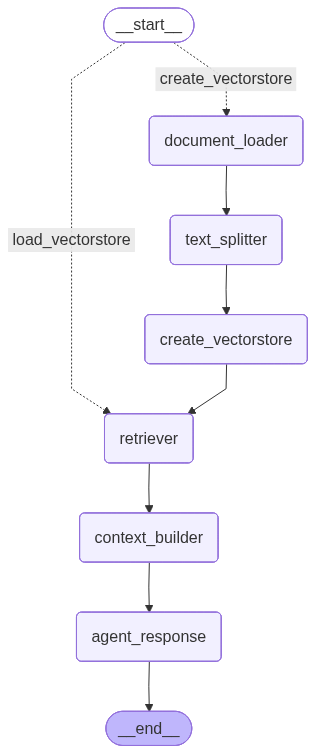

In [70]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

# nodes
workflow.add_node("document_loader", document_loader)
workflow.add_node("text_splitter", text_splitter)
workflow.add_node("create_vectorstore", create_vector_store_manual)
workflow.add_node("retriever", search_chunks)
workflow.add_node("context_builder", context_builder)
workflow.add_node("agent_response", agent_response)

# edges
workflow.add_conditional_edges(
                    START,
                    conditional,
                {
                    "create_vectorstore": "document_loader",
                    "load_vectorstore": "retriever"
                })

# if new vector store
workflow.add_edge("document_loader", "text_splitter")
workflow.add_edge("text_splitter","create_vectorstore")
workflow.add_edge("create_vectorstore", "retriever")



workflow.add_edge("retriever", "context_builder")
workflow.add_edge("context_builder", "agent_response")
workflow.add_edge("agent_response", END)


app = workflow.compile()
app

In [80]:
import uuid


file_path = "../../data/Constitution and law/PAKISTAN PENAL CODE.pdf"
doc_id = file_path.split("/")[-1]


initial_state = {
    "documents_path":file_path ,
    "doc_id": doc_id,
    "collection_name": "legal_docs",
    "messages": HumanMessage(content="Who is public servan?")
}

result = app.invoke(initial_state)

Uploading chunks manually: 100%|██████████| 29/29 [01:44<00:00,  3.59s/it]


Uploaded 574 chunks manually to Supabase


In [81]:
from IPython.display import Markdown,display
Markdown(result["answer"])

A public servant is defined as any person who is in actual possession of the situation of a public servant, whether appointed by the Government or not. This includes various categories such as a Municipal Commissioner, arbitrators, officers of the Government whose duties involve preventing offences, and those empowered to manage property on behalf of the Government, among others. Specifically, the term "public servant" encompasses every person who holds any office by virtue of which they are empowered to perform official functions, regardless of any legal defect in their right to hold that position [Source: PAKISTAN PENAL CODE.pdf - Page 5].

In [84]:
initial_state = {
    "doc_id": doc_id,
    "collection_name": "legal_docs",
    "messages": HumanMessage(content="Who is Fraudulently?")
}

result = app.invoke(initial_state)

In [85]:
Markdown(result["answer"])

A person is said to do a thing fraudulently if he does that thing with intent to defraud but not otherwise [Source: PAKISTAN PENAL CODE.pdf - Page 6].

In [86]:
initial_state = {
    "doc_id": doc_id,
    "collection_name": "legal_docs",
    "messages": HumanMessage(content="local law vs special law?")
}

result = app.invoke(initial_state)

In [87]:
Markdown(result["answer"])

A "special law" is defined as a law applicable to a particular subject, while a "local law" is a law applicable only to a particular part of the territories comprised in Pakistan [41, 42]** (Found in: Chunk ID/Source).